In [ ]:
#https://www.youtube.com/watch?v=0GrciaGYzV0

In [1]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import roc_auc_score

import pandas as pd

X = pd.read_csv("data/train.csv")
y = X.pop("Survived")

In [2]:
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
X["Age"].fillna(X.Age.mean(), inplace=True)
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
numeric_variables = list(X.dtypes[X.dtypes != 'object'].index)
X[numeric_variables].head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,1,3,22.0,1,0,7.2500
1,2,1,38.0,1,0,71.2833
2,3,3,26.0,0,0,7.9250
3,4,1,35.0,1,0,53.1000
4,5,3,35.0,0,0,8.0500


In [5]:
model = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)
model.fit(X[numeric_variables], y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [6]:
model.oob_score_

0.1361695005913669

In [7]:
y_oob = model.oob_prediction_
print('c-stat: ', roc_auc_score(y, y_oob))

c-stat:  0.73995515504


In [8]:
def describe_categorial(X):
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == 'object']].describe().to_html()))

In [9]:
describe_categorial(X)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Nysveen, Mr. Johan Hansen",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [10]:
X.drop(['Name', 'PassengerId', 'Ticket'], axis=1, inplace=True)

In [11]:
def clean_cabin(x):
    try:
        return x[0]
    except TypeError:
        return 'None'
    
X['Cabin'] = X.Cabin.apply(clean_cabin)

In [12]:
categorical_variables = ['Cabin', 'Sex', 'Embarked']

for variable in categorical_variables:
    X[variable].fillna('Missing', inplace=True)
    dummies = pd.get_dummies(X[variable], prefix=variable)
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)

In [13]:
def print_all(X, max_rows=10):
    from IPython.display import display, HTML
    display(HTML(X.to_html(max_rows=max_rows)))

print_all(X)

,Pclass,Age,SibSp,Parch,Fare,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Cabin_T,Sex_female,Sex_male,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S
0,3,22.000000,1,0,7.2500,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
1,1,38.000000,1,0,71.2833,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
2,3,26.000000,0,0,7.9250,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
3,1,35.000000,1,0,53.1000,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
4,3,35.000000,0,0,8.0500,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.000000,0,0,13.0000,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
887,1,19.000000,0,0,30.0000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
888,3,29.699118,1,2,23.4500,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
889,1,26.000000,0,0,30.0000,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0


In [14]:
model = RandomForestRegressor(100, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, y)

print('c-stat: ', roc_auc_score(y, model.oob_prediction_))

c-stat:  0.864671545287


In [15]:
model.feature_importances_

array([  9.20476146e-02,   2.39922758e-01,   4.44657893e-02,
         2.17267435e-02,   2.13160364e-01,   2.66127219e-03,
         3.65899224e-03,   6.23635316e-03,   4.37009051e-03,
         8.58094173e-03,   7.30989139e-04,   6.89594605e-04,
         2.65998481e-02,   1.52486584e-04,   1.54932233e-01,
         1.47313644e-01,   1.07796645e-02,   0.00000000e+00,
         6.15600273e-03,   1.58146186e-02])

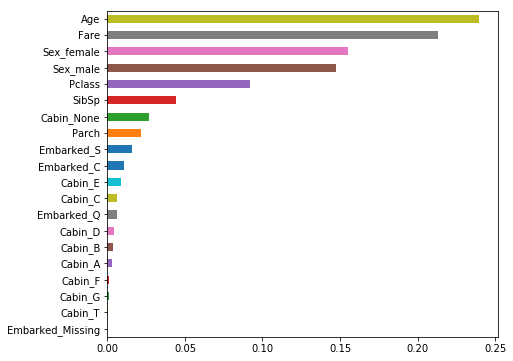

In [20]:
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(7,6));

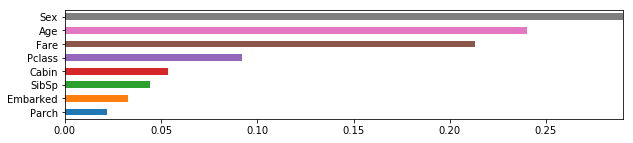

In [39]:
def graph_feature_importance(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_colmns=None):
    if autoscale:
        x_scale = model.feature_importances_.max() + headroom
    else:
        x_scale = 1
    
    feature_dict = dict(zip(feature_names, model.feature_importances_))
    
    if summarized_colmns:
        for col_name in summarized_colmns:
            sum_value = sum(x for i, x in feature_dict.items() if col_name in i)
            
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i]
            
            for i in keys_to_remove:
                feature_dict.pop(i)
                
            feature_dict[col_name] = sum_value
    
    results = pd.Series(list(feature_dict.values()), index=feature_dict.keys())
    results.sort_values(inplace=True)
    results.plot(kind='barh', figsize=(width,len(results)/4), xlim=(0,x_scale));

graph_feature_importance(model, X.columns, summarized_colmns=categorical_variables)

In [43]:
%%timeit
model = RandomForestRegressor(1000, oob_score=True, n_jobs=1, random_state=42)
model.fit(X, y)

3.85 s ± 164 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
%%timeit
model = RandomForestRegressor(1000, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, y)

3.11 s ± 42.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


trees:  30
c-stat:  0.859747653895
trees:  50
c-stat:  0.863047113838
trees:  100
c-stat:  0.864671545287
trees:  200
c-stat:  0.862961897762
trees:  500
c-stat:  0.863332055092
trees:  1000
c-stat:  0.863683571406


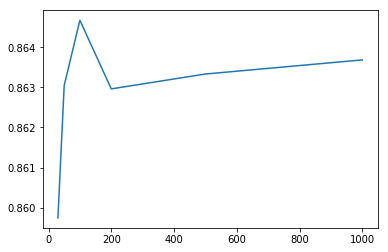

In [45]:
results = []
n_estimator_options = [30, 50, 100, 200, 500, 1000]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1, random_state=42)
    model.fit(X, y)

    print('trees: ', trees)
    
    roc = roc_auc_score(y, model.oob_prediction_)
    print('c-stat: ', roc)
    results.append(roc)
pd.Series(results, n_estimator_options).plot();

auto  option
c-stat:  0.863683571406
None  option
c-stat:  0.863683571406
sqrt  option
c-stat:  0.863358685116
log2  option
c-stat:  0.863358685116
0.9  option
c-stat:  0.863782102494
0.2  option
c-stat:  0.863358685116


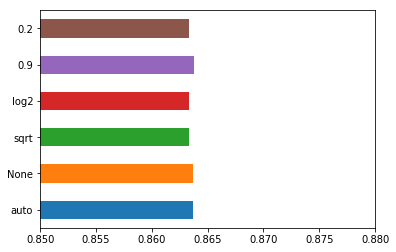

In [48]:
results = []
max_features_options = ['auto', None, 'sqrt', 'log2', 0.9, 0.2]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model.fit(X, y)

    print(max_features, ' option')
    
    roc = roc_auc_score(y, model.oob_prediction_)
    print('c-stat: ', roc)
    results.append(roc)
pd.Series(results, max_features_options).plot(kind='barh', xlim=(.85, .88));

1  min samples
c-stat:  0.863683571406
2  min samples
c-stat:  0.869677989753
3  min samples
c-stat:  0.871361007254
4  min samples
c-stat:  0.873584614237
5  min samples
c-stat:  0.874311613886
6  min samples
c-stat:  0.873922815539
7  min samples
c-stat:  0.873299672983
8  min samples
c-stat:  0.871866977705
9  min samples
c-stat:  0.869395711501
10  min samples
c-stat:  0.867494327805


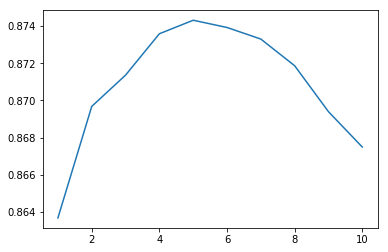

In [49]:
results = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(
        n_estimators=1000,
        oob_score=True,
        n_jobs=-1,
        random_state=42,
        max_features='auto',
        min_samples_leaf=min_samples)
    model.fit(X, y)

    print(min_samples, ' min samples')
    
    roc = roc_auc_score(y, model.oob_prediction_)
    print('c-stat: ', roc)
    results.append(roc)
pd.Series(results, min_samples_leaf_options).plot();

In [50]:
model = RandomForestRegressor(
    n_estimators=1000,
    oob_score=True,
    n_jobs=-1,
    random_state=42,
    max_features='auto',
    min_samples_leaf=5)
model.fit(X, y)
roc = roc_auc_score(y, model.oob_prediction_)
print('c-stat: ', roc)

c-stat:  0.874311613886
